# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 07.12.2021


Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

C:\Users\Oleg\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this case special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing datas

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.951827225405225

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """

    n = X.shape[0]
    error = 0
    all_preds, all_preds_sqr =  np.zeros(n), np.zeros(n)
    all_counts = np.zeros(n)
    all_inds = np.random.choice(n, n, replace=False)
    for i in range(num_runs):
        indices = np.random.choice(X.shape[0], n, replace=True)
        oob_inds = np.setdiff1d(all_inds, indices)

        preds = regressor.fit(X[indices], y[indices]).predict(X)
        error += np.mean( (preds[oob_inds] - y[oob_inds]) ** 2 )
        all_preds[oob_inds] += preds[oob_inds]
        all_preds_sqr[oob_inds] += preds[oob_inds] ** 2
        all_counts[oob_inds] += 1

    nonzeros = np.nonzero(all_counts)[0]
    all_preds = all_preds[nonzeros]
    all_preds_sqr = all_preds_sqr[nonzeros]
    all_counts = all_counts[nonzeros]
    mean_preds = all_preds / all_counts

    bias = np.sum( (mean_preds - y[nonzeros]) ** 2 ) / len(nonzeros)
    variance = np.sum( (all_preds_sqr - all_preds * mean_preds) / all_counts ) / len(nonzeros)
    return bias, variance, error / num_runs

In [ ]:
from sklearn.linear_model import LinearRegression
b, v, e = compute_biase_variance(LinearRegression(), X, y)
print('%.2f, %.2f, %.2f' % (b, v, e))
print(b + v)

23.80, 0.97, 24.84
24.770294023264704


__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

res = pd.DataFrame(index=['bias', 'variance', 'error'])

res['Linear'] = compute_biase_variance(LinearRegression(), X, y)
res['Tree'] = compute_biase_variance(DecisionTreeRegressor(), X, y)
res['Forest'] = compute_biase_variance(RandomForestRegressor(), X, y)

res.head()

,Linear,Tree,Forest
bias,23.737681,10.222466,10.652291
variance,0.948156,13.014569,2.269793
error,24.928744,23.175450,12.963909


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

Вполне себе согласуютсся. Как и обсуждалась, линейная модель характеризуется высоким смещением и низким разбросом, дерево решений - наоборот. Случайный лес находит хороший баланс - низкое смещение и несильно высокий разброс. Кроме того, ошибка у него меньше.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [ ]:
from sklearn.ensemble import BaggingRegressor

res['Linear Bagging'] = compute_biase_variance(BaggingRegressor(LinearRegression()), X, y)
res['Tree Bagging'] = compute_biase_variance(BaggingRegressor(DecisionTreeRegressor()), X, y)
res['Forest Bagging'] = compute_biase_variance(BaggingRegressor(RandomForestRegressor()), X, y)

res.head()

,Linear,Tree,Forest,Linear Bagging,Tree Bagging,Forest Bagging
bias,23.737681,10.222466,10.652291,23.671830,10.790107,11.604361
variance,0.948156,13.014569,2.269793,1.004255,3.374980,1.392332
error,24.928744,23.175450,12.963909,24.646066,14.190496,12.934696


По-хорошему разброс должен уменьшаться в `N` раз, где `N` - число моделей в композиции - в нашем случае `N = n_estimators = 10` по дефолту. Однако такое работает если ковариция двух любых моделей близка к нулю. Очевидно, это не так в нашем случае. Для бэггинга с деревом решений заметно, что корреляция базовых моделей оказалась не особо большой - разброс заметно упал.

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 5

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=None, ax=None, seed=None):
    if ax is None:
        ax = plt.gca()

    n = len(y)
    np.random.seed(seed)
    all_inds = np.random.choice(n, n, replace=False)
    test = np.random.choice(n, num_test_objects, replace=False)
    train = np.setdiff1d(all_inds, test)
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]

    ax.grid()
    m = len(y_train)
    for i in range(num_runs):
        indices = np.random.choice(m, m, replace=True)
        preds = regressor.fit(X_train[indices], y_train[indices]).predict(X_test)
        ax.scatter([i for i in range(num_test_objects)], preds, color='lime', linewidths=2)
    
    ax.scatter([i for i in range(num_test_objects)], y_test, color='black', linewidths=2)
    ax.set_xlabel('test objects')
    ax.set_ylabel('target')
    if title is not None:
        ax.set_title(title)
    return ax


__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

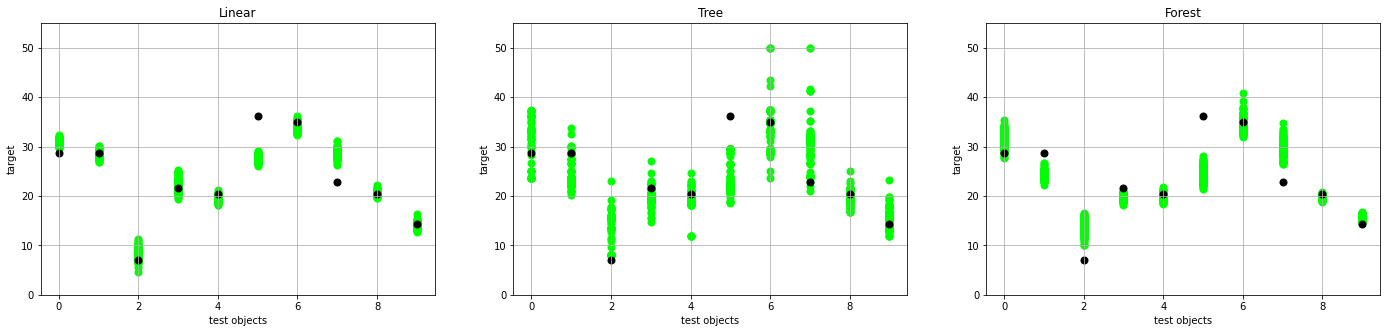

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))
plot_predictions(LinearRegression(), X, y, title='Linear', ax=axes[0], seed=10)
plot_predictions(DecisionTreeRegressor(), X, y, title='Tree', ax=axes[1], seed=10)
plot_predictions(RandomForestRegressor(), X, y, title='Forest', ax=axes[2], seed=10)
for i in range(3):
    axes[i].set_ylim(np.min(y) - 5, np.max(y) + 5)
plt.show()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

Здесь смещение - то, насколько предсказания близки к истинным значениям (близость зеленых точек к черным), разброс - то, насколько сильно кучкуются предсказания (насколько плотно расположены зеленые точки относительно друг друга). На графиках отчетливо видим, что у линейной регрессии очень маленький разброс, чуть больше у случайного леса и наибольший у одного дерева решений. Смещение лучше всего у дерева, чуть хуже у леса, внизу топа - линейная регрессия. Это сложно заметить, но если ориентироваться по объектам 0, 5, 8 и некоторым другим, все становится более-менее понятным.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

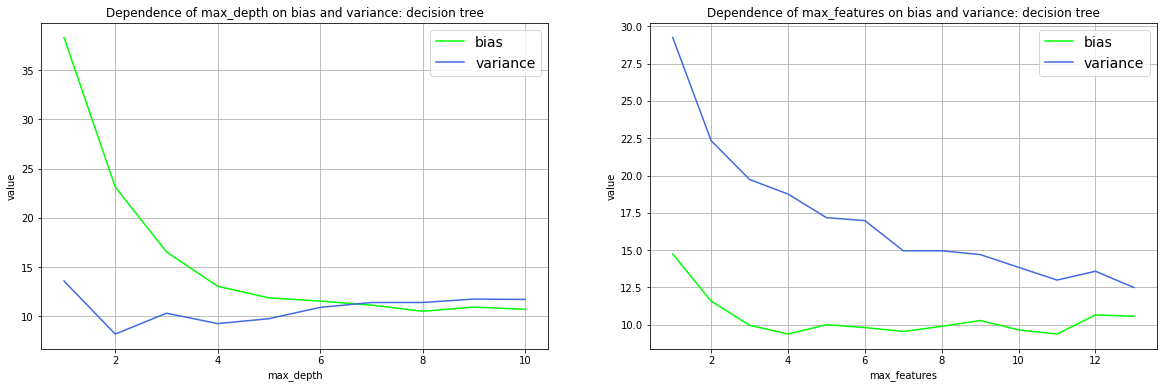

In [ ]:
md = [i + 1 for i in range(10)]
mf = [i + 1 for i in range(X.shape[1])]

arrs = {'max_depth':md, 'max_features':mf}
bias_d, var_d, bias_f, var_f = [], [], [], []
for d in md:
    regressor = DecisionTreeRegressor(max_depth=d)
    b, v, _ = compute_biase_variance(regressor, X, y, num_runs=100)
    bias_d.append(b)
    var_d.append(v)
for f in mf:
    regressor = DecisionTreeRegressor(max_features=f)
    b, v, _ = compute_biase_variance(regressor, X, y, num_runs=100)
    bias_f.append(b)
    var_f.append(v)

bias = np.array([bias_d, bias_f], dtype=object)
var = np.array([var_d, var_f], dtype=object)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
for i, pr in enumerate(['max_depth', 'max_features']):
    axes[i].plot(arrs[pr], bias[i], color='lime', label='bias')
    axes[i].plot(arrs[pr], var[i], color='royalblue', label='variance')
    axes[i].set_xlabel(pr)
    axes[i].set_ylabel('value')
    axes[i].set_title('Dependence of ' + pr + ' on bias and variance: decision tree')
    axes[i].grid()
    axes[i].legend(shadow=False, fontsize=14)

plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

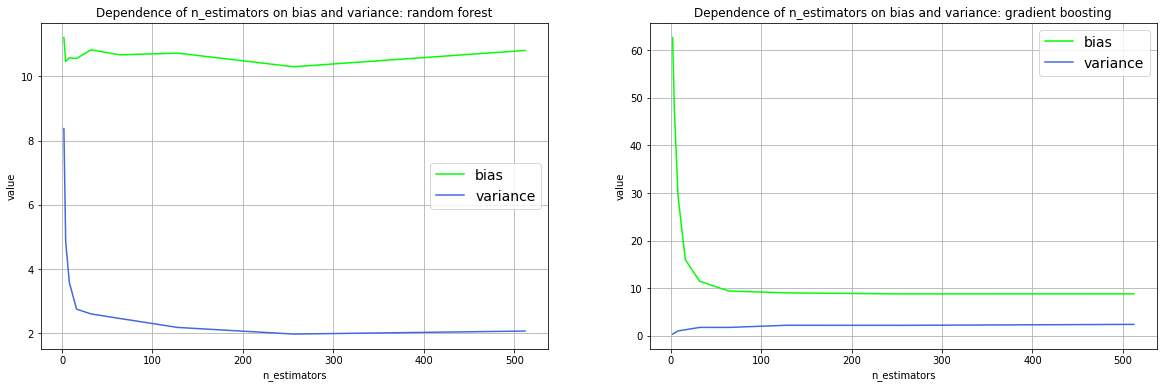

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
Ns = 2 ** np.arange(1, 10)

bias_b, var_b, bias_f, var_f = [], [], [], []
for N in Ns:
    regressor = RandomForestRegressor(n_estimators=N)
    b, v, _ = compute_biase_variance(regressor, X, y, num_runs=100)
    bias_f.append(b)
    var_f.append(v)

    regressor = GradientBoostingRegressor(n_estimators=N)
    b, v, _ = compute_biase_variance(regressor, X, y, num_runs=100)
    bias_b.append(b)
    var_b.append(v)

bias = np.array([bias_f, bias_b], dtype=object)
var = np.array([var_f, var_b], dtype=object)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
for i, nm in enumerate(['random forest', 'gradient boosting']):
    axes[i].plot(Ns, bias[i], color='lime', label='bias')
    axes[i].plot(Ns, var[i], color='royalblue', label='variance')
    axes[i].set_xlabel('n_estimators')
    axes[i].set_ylabel('value')
    axes[i].set_title('Dependence of n_estimators on bias and variance: ' + nm)
    axes[i].grid()
    axes[i].legend(shadow=False, fontsize=14)

plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

Рассмотрим одно решающее дерево и зависимость его смещения и разброса от максимальной глубины. Очевидно, что увеличивая глубину, мы улучшаем смещение и качество предсказаний. Напротив, увеличивая глубину, мы увеличиваем и разброс, так как дерево решений имеет свойство затачиваться под обучающую выборку, а значит, ему свойственно выдавать менее хорошие результаты на другой выборке. Конечно, чем больше глубина, тем больше шанс переобучиться.

Теперь рассмотрим ту же зависимость относительно максимального числа признаков. Здесь имеет место проблема "золотых признаков" - признаков, которые имеют большой вес, без которых (я бы сказал любая) модель не способна выдать хорошего качества. В нашем случае мы видим, что нет признаков с сильно большим весом, но, тем не менее, модель выдает посредственные прогнозы с малым числом признаков. По мере увеличения `max_features` смещение не меняется супер-сильно (что связано с особенностями обучения дерева), чего не скажешь о разбросе. На мой взгляд распределение выборки задается несколькими признаками, поэтому если мы берем какой-то один, то мы никак не получим хорошей обобщающей способности, из-за чего результат на различных выборках будет сильно разниться. Я имею в виду, что увеличивая `max_features`, мы улучшаем и обобщающую способность модели - чем больше у нас признаков в арсенале, тем лучше мы можем уловить закономерности генеральной совокупности. Стоит отметить, что это может работать не так с выборками, где очень много признаков - тут уже стоит вычленять наиболее значимые.

Случайный лес в принципе возволяет объединить несмещенные базовые модели в композицию с низкой дисперсией. Путем рандомизации понижается корреляция между двумя базовыми моделями. На лекции отмечалось, что `n_estimators` можно выбирать сколько угодно большим - особо изменений не будет. Это мы и наблюдаем на графике.

В композиции градиентного бустинга каждая следующая модель исправляет ошибки предыдущей. Отсюда понятно, почему у нас смещение имеет резкий экспоненциальный спад. Затем оно остается на одном и тот же уровне (очень близком к константному) за счет возможности бустинга поиска лучшей функции, восстанавливающей истинную зависимость в выборке. Разброс остается примерно на том же уровне (с небольшим увеличением при росте `n_estimators`). Думаю, это связано с тем, как вообще работает (и обучается) градиентный бустинг - ведь выходит так, что каждая новая модель немного увеличивает разброс.

__P.S. Спасибо Соне за то, что она есть.__